In [2]:
from spectral_spatial_simulation import LookupTableWET
from file import Configurator
from prettyconsole import Console
import file

In [3]:
config_file_name = "paths_14032025.json"
configurator = Configurator(path_folder="../config/",
                            file_name=config_file_name)

# TO LOAD THE MAPS ANS INTERPOLATE IT 

In [3]:
configurator.load()

loaded_B1_map = file.Maps(configurator=configurator, map_type_name="B1").load_file()
loaded_B1_map_shape = loaded_B1_map.loaded_maps.shape

loaded_B0_map = file.Maps(configurator=configurator, map_type_name="B0").load_file()
loaded_B0_map = loaded_B0_map.interpolate_to_target_size(target_size=loaded_B1_map_shape, order=1)


loaded_GM_map = file.Maps(configurator=configurator, map_type_name="GM_segmentation").load_file()
loaded_WM_map = file.Maps(configurator=configurator, map_type_name="WM_segmentation").load_file()
loaded_CSF_map = file.Maps(configurator=configurator, map_type_name="CSF_segmentation").load_file()


loaded_GM_map = loaded_GM_map.interpolate_to_target_size(target_size=loaded_B1_map_shape, order=1)
loaded_WM_map = loaded_WM_map.interpolate_to_target_size(target_size=loaded_B1_map_shape, order=1)
loaded_CSF_map = loaded_CSF_map.interpolate_to_target_size(target_size=loaded_B1_map_shape, order=1)
Console.printf("info", "Interpolated all maps via 'order 1' to B1 map shape")

[  1  ][  info   ] >> Maps object: The provided path points to a file                                                      
[  2  ][  info   ] >> Loading nii file for map type B1                                                                     
[  3  ][ success ] ---v  (collected several lines)                      
                      Loaded nii map: B1Map_TargetRes.nii | Shape: (180, 180, 109) | Values range: [-19.237, 102.543] | Unique values: 334682
                      
[  4  ][  info   ] >> Maps object: The provided path points to a file                                                      
[  5  ][  info   ] >> Loading nii file for map type B0                                                                     
[  6  ][ success ] ---v  (collected several lines)                      
                      Loaded nii map: B0Map_TargetRes.nii | Shape: (180, 180, 109) | Values range: [-533.767, 1068.09] | Unique values: 1471604
                      
[  7  ][ warning ] ---v  (

# TO CREATE THE LOOKUP TABLE

[ 24  ][  info   ] ---v                       
                      Start creating the Lookup Table for WET (water suppression enhanced through T1 effects)
                       => Axis 1: B1 scale | Resolution:  0.050 | Range:  0.000: 3.000
                       => Axis 2: T1/TR    | Resolution:  0.083 | Range:  0.500: 8.333


100%|███████████████████████████████████████████| 95/95 [00:05<00:00, 18.26it/s]


[ 25  ][ success ] >> Created WET lookup table with 5795 entries. Values Range: [2.8850151969148033e-05, 1.0]              


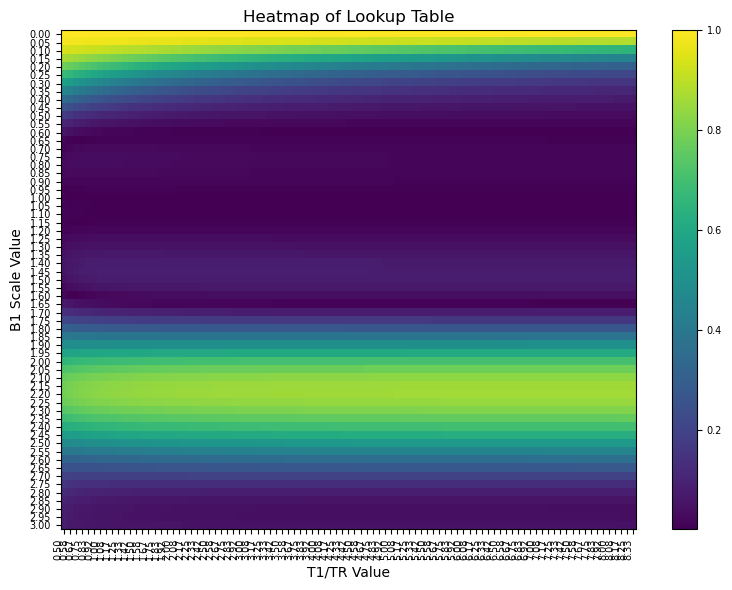

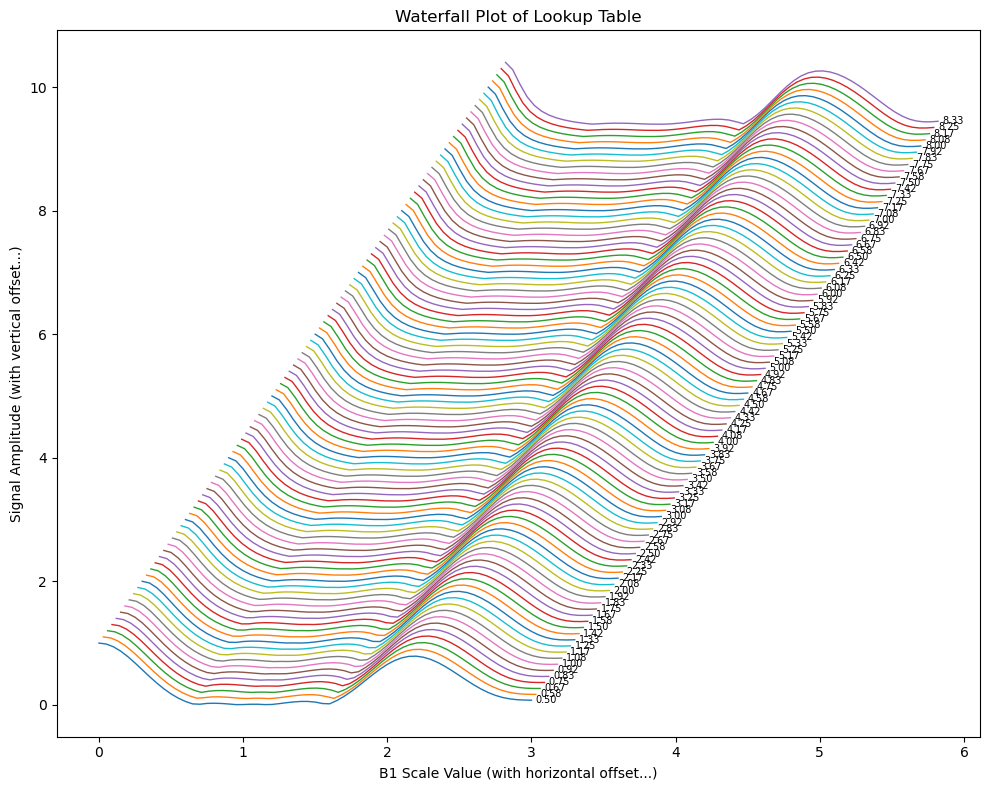

In [4]:
TR=600
lookup_table_WET_test = LookupTableWET(T1_range=[300, 5000],
                                       T1_step_size=50,
                                       T2=250,
                                       B1_scales_inhomogeneity=[1e-10,3], # TODO
                                       B1_scales_gauss=[0.01, 1],
                                       B1_scales_inhomogeneity_step_size=0.05,
                                       B1_scales_gauss_step_size=0.05,
                                       TR=TR,
                                       TE=0, # TODO -> why 0???
                                       flip_angle_excitation_degree=47.0,
                                       flip_angles_WET_degree=[89.2, 83.4, 160.8],
                                       time_gaps_WET=[30, 30, 30],
                                       off_resonance=0)
lookup_table_WET_test.create()
lookup_table_WET_test.plot()
#lookup_table_WET_test.plot_waterfall_interactive()
lookup_table_WET_test.plot_waterfall()

# Create map from lookup table

In [5]:
import numpy as np

scaled_B1_map = loaded_B1_map.loaded_maps / 39.0
scaled_B1_map[scaled_B1_map < 0] = 0.001
Console.printf("info", "set values < 0 to 0 in scaled B1 map (map/39°)")

# TODO: get entry is in only get index to get entry!!!!!
# TODO: scaled B1_map -> consider - values or to set it to 0 ????
# TODO: Then, also load gray and white matter!!!

# (#1) Source T1 GM & WM for 7T: https://pmc.ncbi.nlm.nih.gov/articles/PMC3375320/
T1_GM = (1550+1804+1940+1550+1950+2132+2007+2000) / 8 #ms      (#1)
T1_WM = (890+1043+1130+950+1200+1220+1357+1500) / 8 #ms        (#1)
T1_CSF = 4470 #ms (average T1 for CSF was given in the paper)  (#1)

T1_over_TR_GM_map = loaded_GM_map.loaded_maps * (T1_GM/TR)
T1_over_TR_WM_map = loaded_WM_map.loaded_maps * (T1_WM/TR)
T1_over_TR_CSF_map = loaded_CSF_map.loaded_maps * (T1_CSF/TR)

# T1_over_TR_GM_map + T1_over_TR_WM_map + T1_over_TR_CSF_map --> lookup_table_WET_test.simulated_data.get_value

Console.add_lines("Scaled maps:")
Console.add_lines(f" => GM min: {np.min(T1_over_TR_GM_map)}; max: {np.max(T1_over_TR_GM_map)}")
Console.add_lines(f" => WM min: {np.min(T1_over_TR_WM_map)}; max: {np.max(T1_over_TR_WM_map)}")
Console.add_lines(f" => CSF min: {np.min(T1_over_TR_CSF_map)}; max: {np.max(T1_over_TR_CSF_map)}")
Console.printf_collected_lines("info")
#sys.exit()

#print(np.min(scaled_B1_map.flatten()), np.max(scaled_B1_map.flatten()))
#print(np.full_like(scaled_B1_map, 1).flatten()))
#lookup_table_WET_test.simulated_data.set_interpolation_method(method="linear")
lookup_table_WET_test.simulated_data.set_interpolation_method(method="linear")

#result_GM = lookup_table_WET_test.simulated_data.get_value(B1_scale_effective=scaled_B1_map, T1_over_TR=T1_over_TR_GM_map)
#result_WM = lookup_table_WET_test.simulated_data.get_value(B1_scale_effective=scaled_B1_map, T1_over_TR=T1_over_TR_WM_map)
#result_CSF = lookup_table_WET_test.simulated_data.get_value(B1_scale_effective=scaled_B1_map, T1_over_TR=T1_over_TR_CSF_map)

result_all = lookup_table_WET_test.simulated_data.get_value(B1_scale_effective=scaled_B1_map,
                                                                T1_over_TR=T1_over_TR_GM_map + T1_over_TR_WM_map + T1_over_TR_CSF_map)
Console.printf("success", "Get map from Lookup Table via T1/R = (T1/TR)_GM + (T1/TR)_WM + (T1/TR)_CSF)")

[  2  ][  info   ] >> set values < 0 to 0 in scaled B1 map (map/39°)                                                       
[  3  ][  info   ] ---v  (collected several lines)                      
                      Scaled maps:
                       => GM min: 0.0; max: 3.1110416666666674
                       => WM min: 0.0; max: 1.9354166666666675
                       => CSF min: 0.0; max: 7.450000000000002
                      
[  4  ][ success ] >> Get map from Lookup Table via T1/R = (T1/TR)_GM + (T1/TR)_WM + (T1/TR)_CSF)                          


In [6]:
result_all.shape

(180, 180, 109)

<Figure size 1500x500 with 0 Axes>

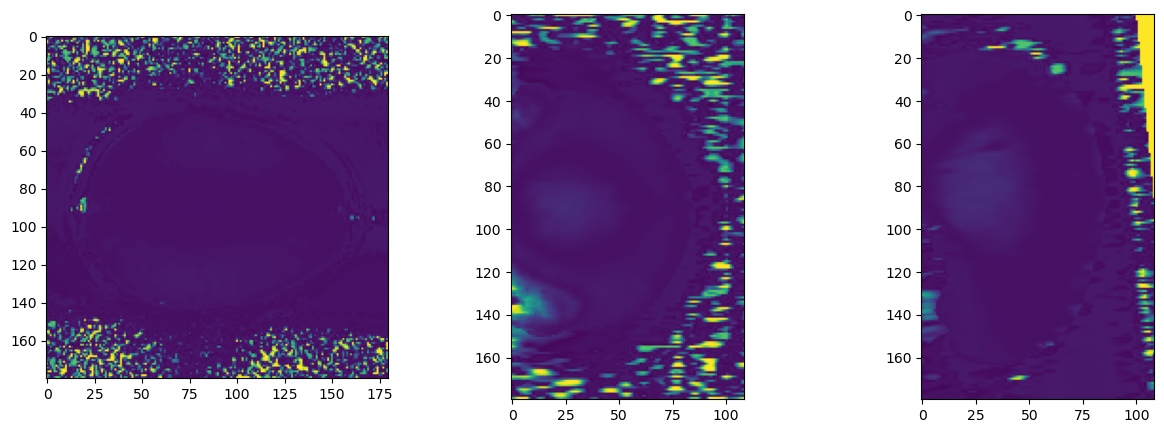

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
fig, axs = plt.subplots(figsize=(15,5), nrows=1, ncols=3)
axs[0].imshow(result_all[:,:,55])
axs[1].imshow(result_all[:,90,:])
axs[2].imshow(result_all[90,:,:])

# Plot combination GM+WM+CSF

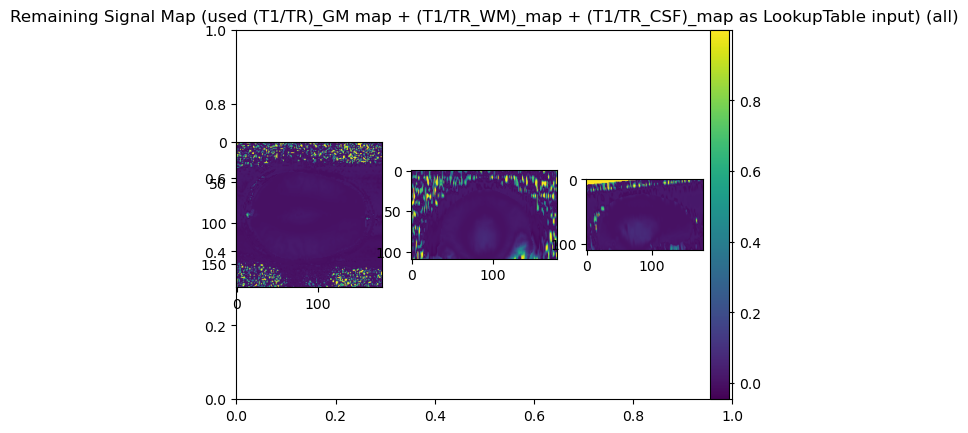

In [8]:
plt.figure(4)
plt.title("Remaining Signal Map (used (T1/TR)_GM map + (T1/TR_WM)_map + (T1/TR_CSF)_map as LookupTable input) (all)")
plt.subplot(1, 3, 1)
plt.imshow(result_all[:, :, 50])
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(result_all[:, 90, :]))
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(result_all[90, :, :]))
plt.colorbar()
plt.show()

# To incorporate the B0 map and Gauss Pulse

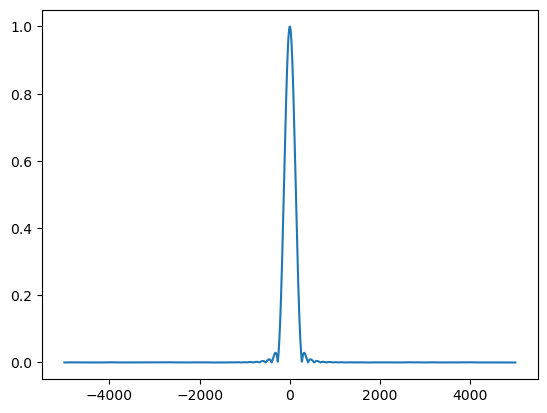

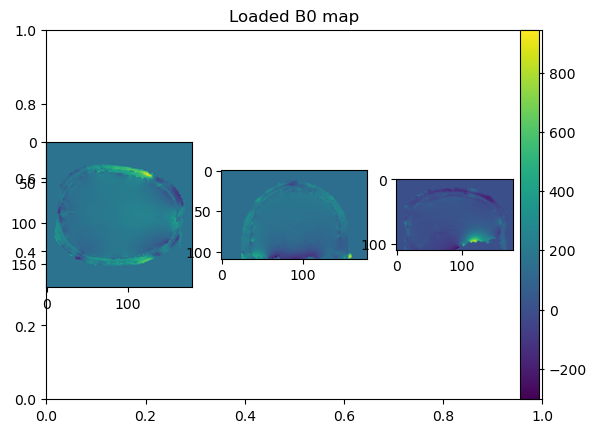

In [9]:
import scipy.io as sio

path_gauss_wet = configurator.data["path"]["pulse"]["gauss_wet"]
gauss_wet_pulse = sio.loadmat(path_gauss_wet)
amplitude_pulse = gauss_wet_pulse["Pulse1_Freq"].squeeze()
frequency_pulse = gauss_wet_pulse["Freq_Vec"].squeeze()

import matplotlib.pyplot as plt
plt.plot(frequency_pulse, amplitude_pulse)
plt.show()

plt.figure(4)
plt.title("Loaded B0 map")
plt.subplot(1, 3, 1)
plt.imshow(loaded_B0_map.loaded_maps[:, :, 50])
plt.subplot(1, 3, 2)
plt.imshow(np.rot90(loaded_B0_map.loaded_maps[:, 90, :]))
plt.subplot(1, 3, 3)
plt.imshow(np.rot90(loaded_B0_map.loaded_maps[90, :, :]))
plt.colorbar()
plt.show()


from scipy.interpolate import interp1d
# to create interpolation function:
interp_func = interp1d(frequency_pulse, amplitude_pulse)

loaded_B0_map_flat = loaded_B0_map.loaded_maps.ravel()
scaled_B0_map_wet_pulse = np.empty_like(loaded_B0_map_flat)

In [10]:
# =============================================================================================================================
# 1 Understand the problem!
#   --> have shape 180 x 180 x 109 MB --> yields ~27 MB --> lets calculate with 30 MB --> thus using 1000 at once yields 30000 MB (30 GB)
#
#
#
dummy = np.empty((180, 109), dtype=np.float64)
# 2 Develop solutions
Console.start_timer()
result_all_gauss = lookup_table_WET_test.simulated_data.get_value(
    B1_scale_effective=dummy,
    T1_over_TR=T1_over_TR_GM_map + T1_over_TR_WM_map + T1_over_TR_CSF_map)
Console.stop_timer()
sys.exit()
Console.printf("info", "Scaling B0 values based on pulse")
# for just one Δf_B0 --> need A(B1_scale * B1_Gauss(Δf + Δf_B0))
delta_f = 0
for i, item in tqdm(enumerate(loaded_B0_map_flat), total=len(loaded_B0_map_flat)):
    scaled_B0_map_wet_pulse[i] = interp_func(delta_f + -1*loaded_B0_map_flat[i]) # TODO: Added minus as Bernhard told!
scaled_B0_map_wet_pulse = scaled_B0_map_wet_pulse.reshape(loaded_B0_map.loaded_maps.shape)
#amplitude_at_freq = interp_func(freq_to_find)
# =============================================================================================================================
for i in tqdm(range(500000), total=500000):
    result_all_gauss = lookup_table_WET_test.simulated_data.get_value(B1_scale_effective=scaled_B1_map * scaled_B0_map_wet_pulse,
                                                                      T1_over_TR=T1_over_TR_GM_map + T1_over_TR_WM_map + T1_over_TR_CSF_map)
Console.printf("success", "Get map from Lookup Table via T1/R = (T1/TR)_GM + (T1/TR)_WM + (T1/TR)_CSF) AND Gauss(B0)")
# TODO -B0?
plt.figure(5)
plt.title("Remaining Signal Map (used (T1/TR)_GM map + (T1/TR_WM)_map + (T1/TR_CSF)_map as LookupTable input) + Gauss Pulse")
plt.subplot(2, 3, 1)
plt.imshow(result_all_gauss[:, :, 50])
plt.subplot(2, 3, 2)
plt.imshow(np.rot90(result_all_gauss[:, 90, :]))
plt.subplot(2, 3, 3)
plt.imshow(np.rot90(result_all_gauss[90, :, :]))
plt.colorbar()
plt.subplot(2, 3, 4)
plt.imshow(np.log2(result_all_gauss[:, :, 50]+0.1))
plt.imshow(np.log2(result_all_gauss[:, :, 50]+0.1))
plt.subplot(2, 3, 5)
plt.imshow(np.log2(np.rot90(np.abs(result_all_gauss[:, 90, :]+0.1))))
plt.subplot(2, 3, 6)
plt.imshow(np.log2(np.rot90(result_all_gauss[90, :, :]+0.1)))
plt.colorbar()
plt.show()

         START TIMER          


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 180) + inhomogeneous part.